In [1]:
cd ./Downloads/GSE271898_RAW/

/Users/seokim/Downloads/GSE271898_RAW


<h1>Data Cleaning</h1>

In [3]:
import pandas as pd
import glob

# Get a list of all .txt files in the current directory
file_list = glob.glob("*.txt")

# Read each file into a dictionary of dataframes
dataframes = {file: pd.read_csv(file, sep='\t', index_col = 'ensembl_id') for file in file_list}

# Print the first few rows of each file to confirm
for file, df in dataframes.items():
    print(f"File: {file}")
    print(df.head())
    print("\n")

File: GSM8388688_Control_Mock2.raw.counts.txt
                 Control_Mock2
ensembl_id                    
ENSG00000223972              0
ENSG00000227232             51
ENSG00000243485              0
ENSG00000237613              0
ENSG00000268020              0


File: GSM8388689_Control_PR81.raw.counts.txt
                 Control_PR81
ensembl_id                   
ENSG00000223972             0
ENSG00000227232            12
ENSG00000243485             0
ENSG00000237613             0
ENSG00000268020             0


File: GSM8388690_Control_PR82.raw.counts.txt
                 Control_PR82
ensembl_id                   
ENSG00000223972             0
ENSG00000227232            15
ENSG00000243485             0
ENSG00000237613             0
ENSG00000268020             0


File: GSM8388691_CICKO_Mock1.raw.counts.txt
                 CIC_KO_Mock1
ensembl_id                   
ENSG00000223972             0
ENSG00000227232            24
ENSG00000243485             0
ENSG00000237613            

In [18]:
import pandas as pd
import glob
import mygene

# Initialize MyGeneInfo
mg = mygene.MyGeneInfo()

def ensembl_to_symbol(ensembl_ids):
    """
    Converts a list of Ensembl IDs to gene symbols.

    Args:
      ensembl_ids: A list of Ensembl IDs (strings).

    Returns:
      A dictionary where keys are Ensembl IDs and values are corresponding gene symbols.
      If a symbol is not found, the value will be None.
    """
    results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol',
                           species='mouse', returnall=True, as_dataframe=True, 
                           df_index=True)

    mapping = {}
    for index, row in results['out'].iterrows():
        mapping[index] = row['symbol'] if 'symbol' in row else None
    return mapping

In [33]:
alldata = pd.concat(dataframes.values(), axis=1)

In [87]:
alldata.dropna()

,Control_Mock2,Control_PR81,Control_PR82,CIC_KO_Mock1,CIC_KO_Mock2,Control_Mock1,CIC_KO_PR81,CIC_KO_PR82
ensembl_id,,,,,,,,
ENSG00000223972,0,0,0,0,0,1,0,0
ENSG00000227232,51,12,15,24,23,187,21,21
ENSG00000243485,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0
ENSG00000268020,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
ENSG00000198695,5427,3569,4119,2709,2255,27681,3173,2667
ENSG00000210194,0,0,0,0,0,0,0,0
ENSG00000198727,30685,20831,24971,17662,17538,131302,19783,17565


<h1>Quality Control</h1>

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [53]:
log_data = np.log2(alldata)

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


Text(0.5, 1.0, 'Log transformed data')

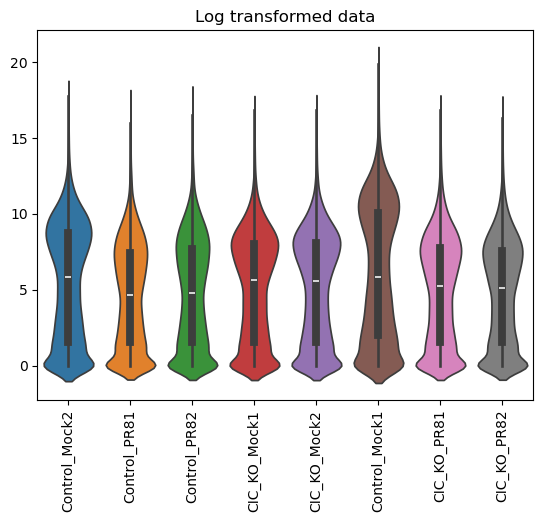

In [69]:
sns.violinplot(log_data)
plt.xticks(rotation=90)
plt.title("Log transformed data")

<h2>Normalization</h2>

In [59]:
import qnorm

In [63]:
normalized = qnorm.quantile_normalize(log_data)

Text(0.5, 1.0, 'Log Transformed, Quantile Normalized Data')

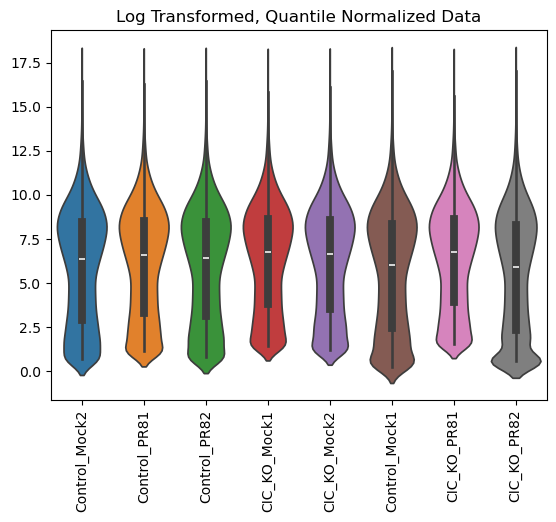

In [71]:
sns.violinplot(normalized)
plt.xticks(rotation=90)
plt.title("Log Transformed, Quantile Normalized Data")

<h1>PCA</h1>

In [102]:
na_omitted = normalized.replace([np.inf, -np.inf], np.nan).dropna()

Text(0.5, 1.0, 'NaN Omitted Data Values From Log-Quantile-Transformed Data(no 0s)')

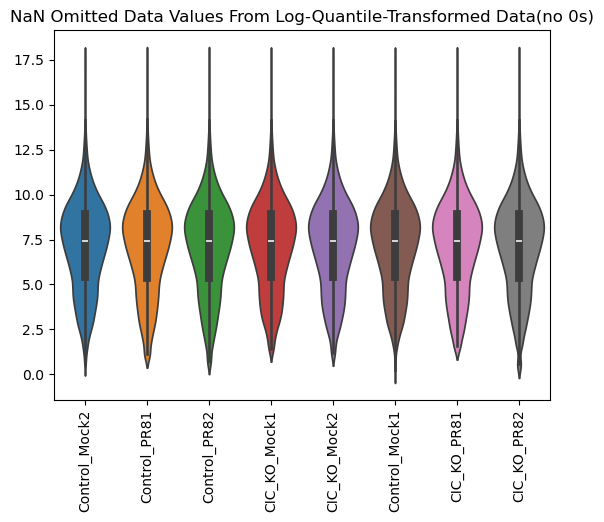

In [112]:
sns.violinplot(na_omitted)
plt.xticks(rotation=90)
plt.title("NaN Omitted Data Values From Log-Quantile-Transformed Data(no 0s)")

<h1>PCA</h1>

In [117]:
from sklearn.decomposition import PCA

In [157]:
transposed = na_omitted.transpose()

In [159]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(transposed)

In [179]:
pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"])
pca_df["Sample"] = transposed.index

In [191]:
pca_df['Sample'] = ['Mock',
                   'PR8',
                   'PR8',
                   'Mock',
                   'Mock',
                   'Mock',
                   'PR8', 
                   'PR8']

In [173]:
pca_df['Sample'] = ['Control',
                    'Control',
                    'Control',
                    'CIC_KO',
                    'CIC_KO',
                    'Control',
                    'CIC_KO',
                    'CIC_KO',]

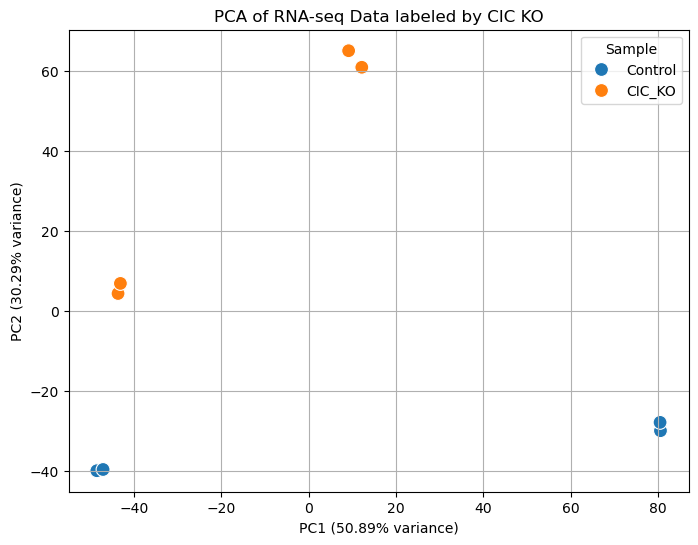

In [177]:
# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue = 'Sample',s=100, palette="tab10")
plt.title("PCA of RNA-seq Data labeled by CIC KO")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
plt.legend(title="Sample")
plt.grid(True)
plt.show()


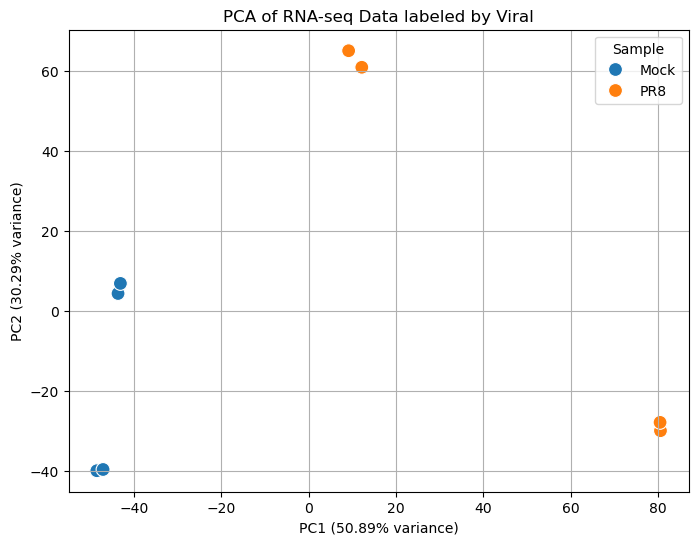

In [193]:
# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue = 'Sample',s=100, palette="tab10")
plt.title("PCA of RNA-seq Data labeled by Viral")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
plt.legend(title="Sample")
plt.grid(True)
plt.show()


<h1>Differential Expression</h1>

Control
- Mock vs. PR8

KO
- Mock vs. PR8

Mock
- Control vs KO

PR8
- Control vs. KO

In [588]:
alldata.columns

Index(['Control_Mock1', 'Control_Mock2', 'Control_PR81', 'Control_PR82',
       'CIC_KO_Mock1', 'CIC_KO_Mock2', 'CIC_KO_PR81', 'CIC_KO_PR82'],
      dtype='object')

In [626]:
alldata = alldata.replace(0, np.nan).dropna()

In [628]:
alldata = alldata[["Control_Mock1", "Control_Mock2", "Control_PR81", "Control_PR82",
        "CIC_KO_Mock1", "CIC_KO_Mock2", "CIC_KO_PR81", "CIC_KO_PR82"]]

In [630]:
# Load count data (Replace with actual file path)
count_data = alldata

# Load metadata (Condition: Mock vs PR8, CIC KO vs WT)
# Define metadata
metadata = pd.DataFrame({
    "Sample": [
        "Control_Mock1", "Control_Mock2", "Control_PR81", "Control_PR82",
        "CIC_KO_Mock1", "CIC_KO_Mock2", "CIC_KO_PR81", "CIC_KO_PR82"
    ],
    "Condition": ["Mock", "Mock", "PR8", "PR8", "Mock", "Mock", "PR8", "PR8"],
    "Genotype": ["WT", "WT", "WT", "WT", "CIC_KO", "CIC_KO", "CIC_KO", "CIC_KO"]
})

# Set the sample names as the index
metadata.set_index("Sample", inplace=True)

# Ensure metadata and count_data match
print(count_data.head())
print(metadata)

                 Control_Mock1  Control_Mock2  Control_PR81  Control_PR82  \
ensembl_id                                                                  
ENSG00000227232          187.0           51.0          12.0          15.0   
ENSG00000225630          317.0           79.0          53.0          65.0   
ENSG00000237973         7243.0         1664.0        1039.0        1241.0   
ENSG00000248527        36654.0         6934.0        5367.0        6213.0   
ENSG00000198744           70.0           10.0           7.0           8.0   

                 CIC_KO_Mock1  CIC_KO_Mock2  CIC_KO_PR81  CIC_KO_PR82  
ensembl_id                                                             
ENSG00000227232          24.0          23.0         21.0         21.0  
ENSG00000225630          47.0          43.0         64.0         39.0  
ENSG00000237973         802.0         688.0        551.0        556.0  
ENSG00000248527        4337.0        3912.0       4680.0       3961.0  
ENSG00000198744           5.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In DESeqDataSet(se, design = design, ignoreRank) :
R[write to console]: 
 
R[write to console]:  some variables in design formula are characters, converting to factors



                 Control_Mock1  Control_Mock2  Control_PR81  Control_PR82  \
ensembl_id                                                                  
ENSG00000227232          187.0           51.0          12.0          15.0   
ENSG00000225630          317.0           79.0          53.0          65.0   
ENSG00000237973         7243.0         1664.0        1039.0        1241.0   
ENSG00000248527        36654.0         6934.0        5367.0        6213.0   
ENSG00000198744           70.0           10.0           7.0           8.0   

                 CIC_KO_Mock1  CIC_KO_Mock2  CIC_KO_PR81  CIC_KO_PR82  
ensembl_id                                                             
ENSG00000227232          24.0          23.0         21.0         21.0  
ENSG00000225630          47.0          43.0         64.0         39.0  
ENSG00000237973         802.0         688.0        551.0        556.0  
ENSG00000248527        4337.0        3912.0       4680.0       3961.0  
ENSG00000198744           5.

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



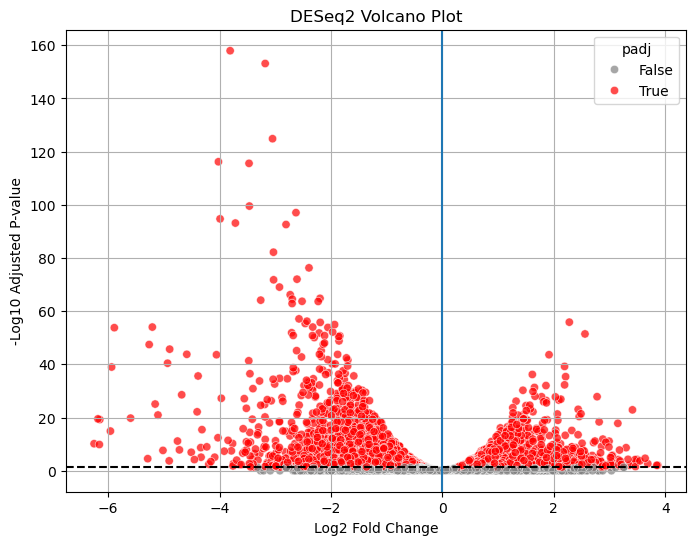

In [750]:
'''
PR8 progression in 

Control vs. CIC KO

'''

pr8 = count_data[['Control_PR81',
           'Control_PR82',
           'CIC_KO_PR81',
           'CIC_KO_PR82']]

metadata = pd.DataFrame({
    "Sample": [
        "Control_PR81", "Control_PR82",
        "CIC_KO_PR81", "CIC_KO_PR82"
    ],
    "Condition": ["PR8", "PR8", "PR8", "PR8"],
    "Genotype": ["WT", "WT","CIC_KO", "CIC_KO",]
})

# Set the sample names as the index
metadata.set_index("Sample", inplace=True)

# Ensure metadata and count_data match
print(count_data.head())
print(metadata)

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# Activate pandas2ri to convert Pandas DataFrames to R dataframes
pandas2ri.activate()

# Load R DESeq2 library
robjects.r('library(DESeq2)')

# Convert count data and metadata to R DataFrame
r_counts = pandas2ri.py2rpy(pr8)
r_metadata = pandas2ri.py2rpy(metadata)

# Run DESeq2
robjects.r('''
    run_deseq2 <- function(count_data, metadata) {
        dds <- DESeqDataSetFromMatrix(countData = count_data, 
                                      colData = metadata, 
                                      design = ~ Genotype)
        dds <- DESeq(dds)
        res <- results(dds, alpha=0.05)  # alpha = significance threshold
        res$padj[is.na(res$padj)] <- 1  # Handle NA p-values
        return(as.data.frame(res))
    }
''')

# Call the R function
deseq2_results = robjects.r['run_deseq2'](r_counts, r_metadata)

# Convert R DataFrame back to Pandas
deseq2_results_df = pandas2ri.rpy2py(deseq2_results)
deseq2_results_df.index = count_data.index  # Restore gene names
deseq2_results_df

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=deseq2_results_df["log2FoldChange"],
    y=-np.log10(deseq2_results_df["padj"]),
    hue=deseq2_results_df["padj"] < 0.05,  # Significant genes
    palette={True: "red", False: "gray"},
    alpha=0.7
)

plt.title("DESeq2 Volcano Plot")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 Adjusted P-value")
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0)
plt.grid(True)
plt.show()

In [752]:
'''
Ensembl id -> human gene conversion
'''
ensembl_ids = list(deseq2_results_df[deseq2_results_df["padj"] < 0.05].index)

import mygene
mg = mygene.MyGeneInfo()

def convert_ensembl_to_gene_name(ensembl_ids):
  """
  Converts a list of Ensembl IDs to gene names.

  Args:
    ensembl_ids: A list of Ensembl IDs (e.g., ['ENSG00000000457', 'ENSG00000000460']).

  Returns:
    A dictionary where keys are Ensembl IDs and values are corresponding gene names.
    If a gene name is not found for an Ensembl ID, the value will be None.
  """
  results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', returnall=True)
  
  gene_names = {}
  for result in results['out']:
      query = result['query']
      if 'symbol' in result:
          gene_names[query] = result['symbol']
      else:
          gene_names[query] = None
  return gene_names

# Example usage:
gene_names = convert_ensembl_to_gene_name(ensembl_ids)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
98 input query terms found no hit:	['ENSG00000272796', 'ENSG00000236624', 'ENSG00000272091', 'ENSG00000223380', 'ENSG00000131795', 'ENS


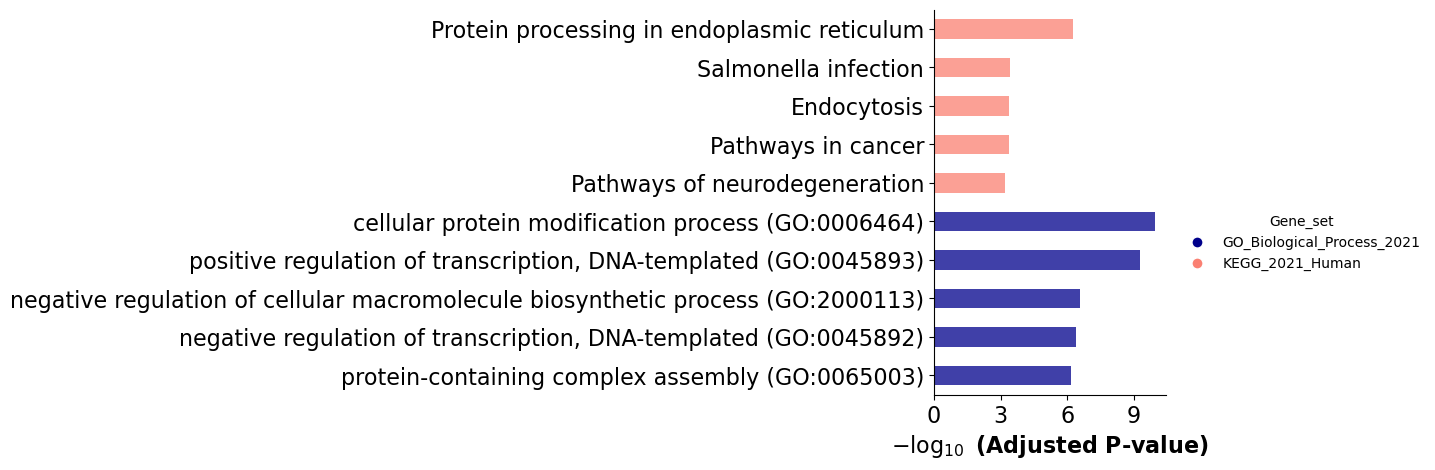

In [754]:
gene_df = pd.DataFrame({"ENS":gene_names.keys(), 
              'genes':gene_names.values()}).dropna()
gene_list = gene_df['genes']

import gseapy as gp
from gseapy import barplot

enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Human', 'GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

# categorical scatterplot
ax = barplot(enr.results,
              column="Adjusted P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              #color=['darkred', 'darkblue'] # set colors for group
              color = {'KEGG_2021_Human': 'salmon', 'GO_Biological_Process_2021':'darkblue'}
             )


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In DESeqDataSet(se, design = design, ignoreRank) :
R[write to console]: 
 
R[write to console]:  some variables in design formula are characters, converting to factors

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


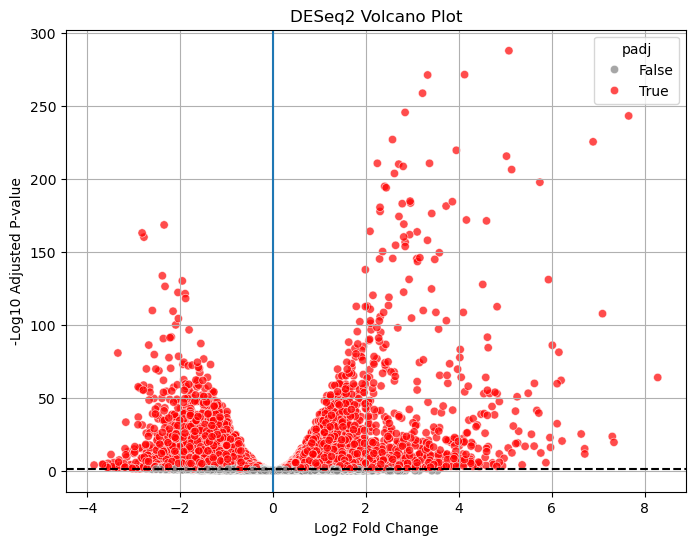

In [756]:
'''
PR8 progression in 

Mock vs. PR82 in Control

'''

pr8 = count_data[['Control_PR81',
           'Control_PR82',
           'Control_Mock1',
           'Control_Mock2']]

metadata = pd.DataFrame({
    "Sample": [
        "Control_PR81", "Control_PR82",
        "Control_Mock1", "Control_Mock2"
    ],
    "Condition": ["PR8", "PR8", "Mock", "Mock"],
    "Genotype": ["WT", "WT","WT", "WT",]
})

# Set the sample names as the index
metadata.set_index("Sample", inplace=True)

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# Activate pandas2ri to convert Pandas DataFrames to R dataframes
pandas2ri.activate()

# Load R DESeq2 library
robjects.r('library(DESeq2)')

# Convert count data and metadata to R DataFrame
r_counts = pandas2ri.py2rpy(pr8)
r_metadata = pandas2ri.py2rpy(metadata)

# Run DESeq2
robjects.r('''
    run_deseq2 <- function(count_data, metadata) {
        dds <- DESeqDataSetFromMatrix(countData = count_data, 
                                      colData = metadata, 
                                      design = ~ Condition)
        dds <- DESeq(dds)
        res <- results(dds, alpha=0.05)  # alpha = significance threshold
        res$padj[is.na(res$padj)] <- 1  # Handle NA p-values
        return(as.data.frame(res))
    }
''')

# Call the R function
deseq2_results = robjects.r['run_deseq2'](r_counts, r_metadata)

# Convert R DataFrame back to Pandas
deseq2_results_df = pandas2ri.rpy2py(deseq2_results)
deseq2_results_df.index = count_data.index  # Restore gene names
deseq2_results_df

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=deseq2_results_df["log2FoldChange"],
    y=-np.log10(deseq2_results_df["padj"]),
    hue=deseq2_results_df["padj"] < 0.05,  # Significant genes
    palette={True: "red", False: "gray"},
    alpha=0.7
)

plt.title("DESeq2 Volcano Plot")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 Adjusted P-value")
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0)
plt.grid(True)
plt.show()

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
2 input query terms found dup hits:	[('ENSG00000261600', 2), ('ENSG00000188660', 2)]
178 input query terms found no hit:	['ENSG00000230699', 'ENSG00000242349', 'ENSG00000272796', 'ENSG00000236624', 'ENSG00000270172', 'ENS


The overlap with interferon-stimulatedg genes are 8 out of 11 genes


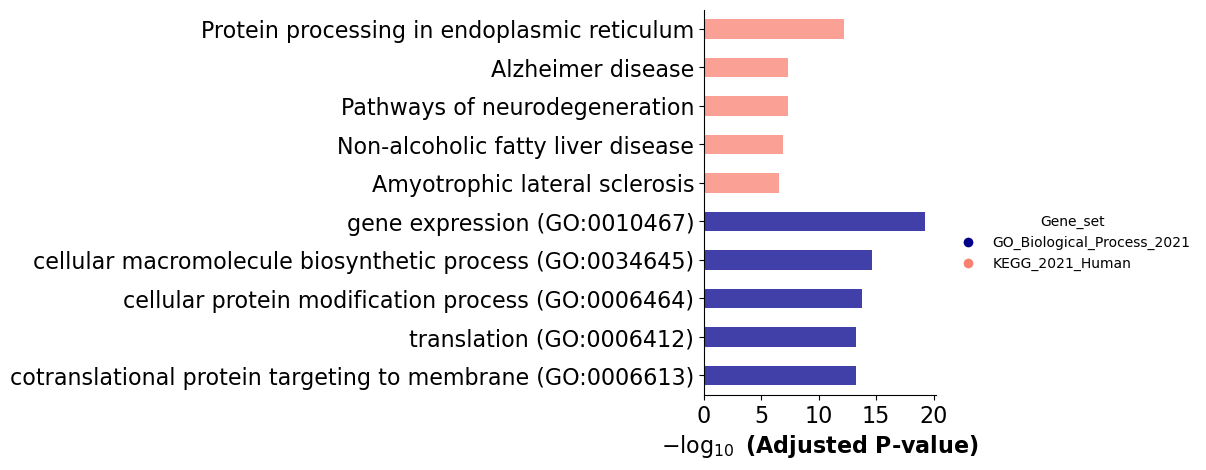

In [798]:
'''
Ensembl id -> human gene conversion
'''
ensembl_ids = list(deseq2_results_df[deseq2_results_df["padj"] < 0.05].index)

import mygene
mg = mygene.MyGeneInfo()

def convert_ensembl_to_gene_name(ensembl_ids):
  """
  Converts a list of Ensembl IDs to gene names.

  Args:
    ensembl_ids: A list of Ensembl IDs (e.g., ['ENSG00000000457', 'ENSG00000000460']).

  Returns:
    A dictionary where keys are Ensembl IDs and values are corresponding gene names.
    If a gene name is not found for an Ensembl ID, the value will be None.
  """
  results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', returnall=True)
  
  gene_names = {}
  for result in results['out']:
      query = result['query']
      if 'symbol' in result:
          gene_names[query] = result['symbol']
      else:
          gene_names[query] = None
  return gene_names

# Example usage:
gene_names = convert_ensembl_to_gene_name(ensembl_ids)

gene_df = pd.DataFrame({"ENS":gene_names.keys(), 
              'genes':gene_names.values()}).dropna()
gene_list = gene_df['genes']

import gseapy as gp
from gseapy import barplot

enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Human', 'GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

# categorical scatterplot
ax = barplot(enr.results,
              column="Adjusted P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              #color=['darkred', 'darkblue'] # set colors for group
              color = {'KEGG_2021_Human': 'salmon', 'GO_Biological_Process_2021':'darkblue'}
             )
ISGs = "IFIT1, IFI6, ISG15, MX1, OAS1, PKR, IRF1, GBP1, IFITM, Viperin, BST2".split(", ")
print(f"The overlap with interferon-stimulatedg genes are {len(np.intersect1d(gene_list.values, ISGs))} out of {len(ISGs)} genes")

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In DESeqDataSet(se, design = design, ignoreRank) :
R[write to console]: 
 
R[write to console]:  some variables in design formula are characters, converting to factors

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


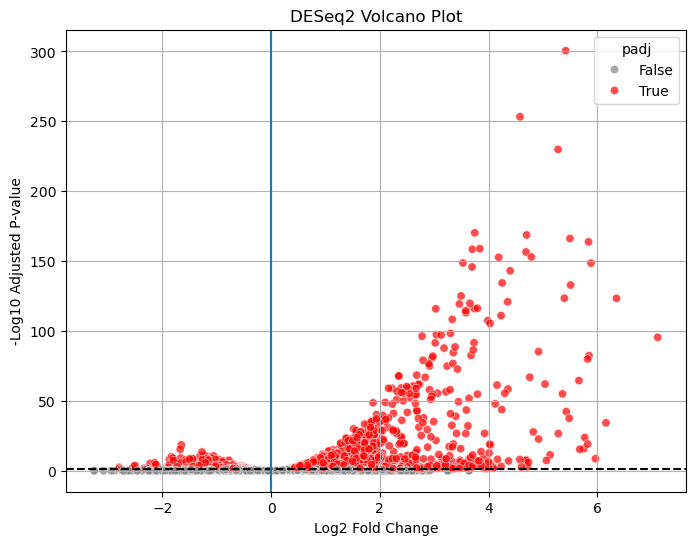

In [800]:
'''
PR8 progression in 
Mock vs. PR82 in KO
'''

KO = count_data[['CIC_KO_PR81',
           'CIC_KO_PR82',
           'CIC_KO_Mock1',
           'CIC_KO_Mock2']]

metadata = pd.DataFrame({
    "Sample": [
        "CIC_KO_PR81", "CIC_KO_PR82",
        "CIC_KO_Mock1", "CIC_KO_Mock2"
    ],
    "Condition": ["PR8", "PR8", "Mock", "Mock"],
    "Genotype": ["CIC_KO", "CIC_KO","CIC_KO", "CIC_KO",]
})

# Set the sample names as the index
metadata.set_index("Sample", inplace=True)

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# Activate pandas2ri to convert Pandas DataFrames to R dataframes
pandas2ri.activate()

# Load R DESeq2 library
robjects.r('library(DESeq2)')

# Convert count data and metadata to R DataFrame
r_counts = pandas2ri.py2rpy(KO)
r_metadata = pandas2ri.py2rpy(metadata)

# Run DESeq2
robjects.r('''
    run_deseq2 <- function(count_data, metadata) {
        dds <- DESeqDataSetFromMatrix(countData = count_data, 
                                      colData = metadata, 
                                      design = ~ Condition)
        dds <- DESeq(dds)
        res <- results(dds, alpha=0.05)  # alpha = significance threshold
        res$padj[is.na(res$padj)] <- 1  # Handle NA p-values
        return(as.data.frame(res))
    }
''')

# Call the R function
deseq2_results = robjects.r['run_deseq2'](r_counts, r_metadata)

# Convert R DataFrame back to Pandas
deseq2_results_df = pandas2ri.rpy2py(deseq2_results)
deseq2_results_df.index = count_data.index  # Restore gene names
deseq2_results_df

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=deseq2_results_df["log2FoldChange"],
    y=-np.log10(deseq2_results_df["padj"]),
    hue=deseq2_results_df["padj"] < 0.05,  # Significant genes
    palette={True: "red", False: "gray"},
    alpha=0.7
)

plt.title("DESeq2 Volcano Plot")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 Adjusted P-value")
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0)
plt.grid(True)
plt.show()

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
30 input query terms found no hit:	['ENSG00000117289', 'ENSG00000121848', 'ENSG00000163486', 'ENSG00000143466', 'ENSG00000180672', 'ENS


The overlap with interferon-stimulatedg genes are 8 out of 11 genes


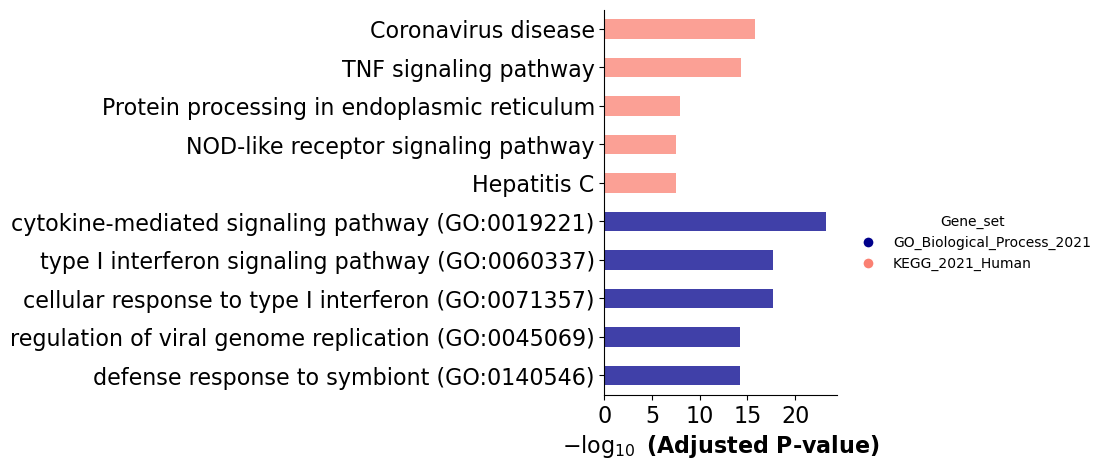

In [802]:
'''
Ensembl id -> human gene conversion
'''
ensembl_ids = list(deseq2_results_df[deseq2_results_df["padj"] < 0.05].index)

import mygene
mg = mygene.MyGeneInfo()

def convert_ensembl_to_gene_name(ensembl_ids):
  """
  Converts a list of Ensembl IDs to gene names.

  Args:
    ensembl_ids: A list of Ensembl IDs (e.g., ['ENSG00000000457', 'ENSG00000000460']).

  Returns:
    A dictionary where keys are Ensembl IDs and values are corresponding gene names.
    If a gene name is not found for an Ensembl ID, the value will be None.
  """
  results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', returnall=True)
  
  gene_names = {}
  for result in results['out']:
      query = result['query']
      if 'symbol' in result:
          gene_names[query] = result['symbol']
      else:
          gene_names[query] = None
  return gene_names

# Example usage:
gene_names = convert_ensembl_to_gene_name(ensembl_ids)

gene_df = pd.DataFrame({"ENS":gene_names.keys(), 
              'genes':gene_names.values()}).dropna()
gene_list = gene_df['genes']

import gseapy as gp
from gseapy import barplot

enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Human', 'GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

# categorical scatterplot
ax = barplot(enr.results,
              column="Adjusted P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              #color=['darkred', 'darkblue'] # set colors for group
              color = {'KEGG_2021_Human': 'salmon', 'GO_Biological_Process_2021':'darkblue'}
             )
ISGs = "IFIT1, IFI6, ISG15, MX1, OAS1, PKR, IRF1, GBP1, IFITM, Viperin, BST2".split(", ")
print(f"The overlap with interferon-stimulatedg genes are {len(np.intersect1d(gene_list.values, ISGs))} out of {len(ISGs)} genes")